## Modules Importing
Import all necessary modules and add PyGRANSO src folder to system path. 

In [1]:
import time
import torch
import sys
## Adding PyGRANSO directories. Should be modified by user
sys.path.append('.')
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct 
from pygranso.private.getNvar import getNvarTorch
import torch.nn as nn
# from torchvision import datasets
# from torchvision.transforms import ToTensor
# from pygranso.private.getObjGrad import getObjGradDL

import scipy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# fix the random seed
torch.manual_seed(55272025)
pass

# w = 8

## Model architecture

In [3]:
class PINN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(PINN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_in = nn.Linear(input_size, hidden_size)
        self.linear_hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_layers - 1)])
        self.linear_out = nn.Linear(hidden_size, 1)
        self.activ = nn.Tanh()
        
    def forward(self, x):
        x = self.linear_in(x)
        x = self.activ(x)
        for l in self.linear_hidden:
            x = l(x)
            x = self.activ(x)
        out = self.linear_out(x)
        return out
    
def get_grads(u, x, t):
    u_t = torch.autograd.grad(
        u, t,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_x = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_xx = torch.autograd.grad(
        u_x, x,
        grad_outputs=torch.ones_like(u_x),
        retain_graph=True,
        create_graph=True
    )[0]

    return u_t,u_x,u_xx

# Exact Penalty with PyGRANSO

In [4]:
train_acc = []
test_acc = []

In [5]:
def f(model, sample_points): # objective
    x, t = sample_points
    xt = torch.cat((x, t), 1)
    u = model(xt)
    
    # Calculate gradients of network
    u_t, u_x, u_xx = get_grads(u, x, t)
    
    # Minimize residual
    res = u_t + u * u_x - 0.01 / np.pi * u_xx
    objective = torch.norm(res)
    # objective = torch.norm(res) / res.numel() # TODO: try
    return objective

def penalty(model, boundary_points, boundary_usol):
    xb, tb = boundary_points
    xtb = torch.cat((xb, tb), 1)
    ub = model(xtb)
    
    boundary_errors = ub - boundary_usol
    return torch.norm(boundary_errors, p=1)
    # return torch.norm(boundary_errors, p=1) / boundary_errors.numel() # TODO: try

def l2_penalty(model, boundary_points, boundary_usol):
    xb, tb = boundary_points
    xtb = torch.cat((xb, tb), 1)
    ub = model(xtb)
    
    boundary_errors = ub - boundary_usol
    return torch.norm(boundary_errors, p=2)
    # return torch.norm(boundary_errors, p=2) / boundary_errors.numel() # TODO: try

# explicitly takes following arguments:
# sample_points: Tensor(2, n_sample_points)
# boundary_points: Tensor(2, n_boundary_points)
# boundary_usol: Tensor(n_boundary_points)
# def phi1(model, mu, sample_points, boundary_points, boundary_usol):
#     return f(model, sample_points) + mu * penalty(model, boundary_points, boundary_usol)

In [6]:
# Adam stuff

# def train_loop(model, mu, optimizer):
#     model.train()
    
#     loss = phi1(model, mu)

#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad()

# def val_loop(dataloader, model):
#     model.eval()
#     # size = len(dataloader.dataset)
#     size = batch_size
#     correct = 0

#     with torch.no_grad():
#         logits = model(inputs)
#         _, predicted = torch.max(logits.data, 1)
#         train_acc.append((predicted == labels).sum().item() / size)
        
#         logits = model(test_inputs)
#         _, predicted = torch.max(logits.data, 1)
#         c = (predicted == test_labels).sum().item()
#         test_acc.append(c / size)
#         correct += c
    
#     correct /= size
#     print(f"Error: \n Accuracy: {(100*correct):>0.1f}% \n")
#     return 100*correct

### 1000 inner epochs

In [7]:
# `f_lambda` takes form `lambda model: loss_of_model_on_training_set`
# `penalty_lambda` takes form `lambda model: penalty_of_model`
# these two lambdas should have other required info (e.g. training points) already baked into them
def exact_penalty_with_pygranso(model, f_lambda, penalty_lambda, mu_0=1., mu_rho=1.1, mu_eps=1e-5):
    mu = torch.tensor([mu_0], dtype=double_precision).to(device)

    # for iteration in range(1000):
    for iteration in range(10): # TODO: try smaller number of iterations (e.g. 2), and/or try Wenjie stopping strategy
        print("Iter", iteration)
        
        # PyGRANSO
        def comb_fn(model):
            # objective function
            # phi1_x_mu = phi1(model, mu, sample_points, boundary_points, boundary_usol)
            phi1_x_mu = f_lambda(model) + mu * penalty_lambda(model)
        
            # inequality constraint, matrix form
            ci = None
        
            # equality constraint 
            ce = None
        
            return [phi1_x_mu,ci,ce]
        
        opts = pygransoStruct()
        # option for switching QP solver. We only have osqp as the only qp solver in current version. Default is osqp
        # opts.QPsolver = 'osqp'
        
        # set an intial point
        # All the user-provided data (vector/matrix/tensor) must be in torch tensor format. 
        # As PyTorch tensor is single precision by default, one must explicitly set `dtype=torch.double`.
        # Also, please make sure the device of provided torch tensor is the same as opts.torch_device.
        nvar = getNvarTorch(model.parameters())
        opts.x0 = torch.nn.utils.parameters_to_vector(model.parameters()).detach().reshape(nvar,1)
        opts.torch_device = device
        opts.opt_tol = 1e-8
        opts.viol_eq_tol = 1e-5
        opts.print_level = 1
        opts.print_frequency = 50
        opts.maxit = 1000  # Inner epochs # TODO: perhaps tune
        
        start = time.time()
        soln = pygranso(var_spec = model,combined_fn = comb_fn, user_opts = opts)
        end = time.time()
        print("Total Wall Time: {}s".format(end - start))
        torch.nn.utils.vector_to_parameters(soln.final.x, model.parameters())
        
        # Exact penalty update
        
        h = penalty_lambda(model)
        print("Objective:", f_lambda(model))
        print("Penalty parameter:", mu)
        print("Penalty:", h)
        if h < 1e-3:  # if h(xk ) ≤ τ
            break

        # Choose new penalty parameter µk+1 > µk ;
        if mu * h > mu_eps:
            mu *= mu_rho

        # Choose new starting point (stay as optimal x1, x2)

        print()

In [12]:
# model = RNN(input_size, hidden_size, num_layers, num_classes).to(device=device, dtype=double_precision)
# exact_penalty_with_pygranso(mu_rho=1.1, mu_eps=1e-5
if __name__ == "__main__":
    # NN hyperparams - width + depth are somewhat arbitrary and vary between papers
    input_size = 2
    hidden_size = 20
    num_layers = 7
    double_precision = torch.double

    data = scipy.io.loadmat('./data/burgers_shock.mat')

    # Create PINN
    model = PINN(input_size, hidden_size, num_layers).to(device=device, dtype=double_precision)
    model.train()

    # Get boundary points along three sides (x = -1, x = 1, t = 0)
    tb_x = data['t']
    xb_t = data['x']
    xb_xlow = np.full_like(tb_x, data['x'][0])
    xb_xhigh = np.full_like(tb_x, data['x'][-1])
    tb_tlow = np.full_like(xb_t, data['t'][0])

    usol_xlow = data['usol'][0,:,None]
    usol_xhigh = data['usol'][-1,:,None]
    usol_tlow = data['usol'][:,0,None]

    xb = np.vstack((xb_xlow, xb_xhigh, xb_t))
    tb = np.vstack((tb_x, tb_x, tb_tlow))
    usolb = np.vstack((usol_xlow, usol_xhigh, usol_tlow))

    xb = torch.Tensor(xb).to(device=device, dtype=double_precision).requires_grad_()
    tb = torch.Tensor(tb).to(device=device, dtype=double_precision).requires_grad_()
    usolb = torch.Tensor(usolb).to(device=device, dtype=double_precision).requires_grad_()
    
    # boundary_usol = usolb # point this global var at the right place
    
    boundary_points = (xb, tb)

    # Ground-truth data - used for testing/evaluation
    usol_full = data['usol']
    usol_tensor = usol_full.flatten()
    usol_tensor = torch.Tensor(usol_tensor).to(device=device, dtype=double_precision)

    # Sample points. Following Dual-Cone Gradient Descent, 10x as many sample points as boundary points
    n_samples = 4560
    xs = -1 + 2 * np.random.rand(n_samples, 1)
    ts = np.random.rand(n_samples, 1)

    xs = torch.Tensor(xs).to(device=device, dtype=double_precision).requires_grad_()
    ts = torch.Tensor(ts).to(device=device, dtype=double_precision).requires_grad_()
    sample_points = (xs, ts)
    
    # Create grid inputs for visualization, comparison to GT
    xgridsize = 256
    tgridsize = 100
    tv, xv = np.meshgrid(data['t'], data['x'])
    tv = torch.Tensor(tv.flatten()).to(device=device, dtype=double_precision).requires_grad_()
    xv = torch.Tensor(xv.flatten()).to(device=device, dtype=double_precision).requires_grad_()
    grid_points = torch.stack((xv, tv)).transpose(0,1)

    # Evaluates the relative L2 error over all grid points
    # Notably, this is NOT what the PINN is minimizing--it only has access to boundary points
    def evaluate(iteration, model, xv, tv, test_usol, error):
        test_points = torch.stack((xv, tv)).transpose(0,1)
        pred_usol = model(test_points)
        L2_error = torch.norm(pred_usol - test_usol)
        error[iteration-1] = L2_error.cpu().detach().item()

        # Save intermediate results (NN outputs + PDE residuals) as images
        if iteration % 25 == 0:
            outimg = pred_usol.cpu().detach().numpy()
            outimg = np.reshape(outimg, (xgridsize, tgridsize))
            plt.imsave("output_imgs/predicted_"+str(iteration)+".png", outimg, origin='upper')
            plt.close()
            evalu_t, evalu_x, evalu_xx = get_grads(pred_usol, xv, tv)
            evalres = evalu_t + torch.flatten(pred_usol) * evalu_x - 0.01 / np.pi * evalu_xx
            outimg = evalres.cpu().detach().numpy()
            outimg = np.reshape(outimg, (xgridsize, tgridsize))
            plt.imsave("output_imgs/pderesidual_"+str(iteration)+".png", outimg, vmin=-3, vmax=3, origin='upper')
            plt.close()

    # Tensors have fixed size and we need to modify in-place, so initialize with maximum possible size
    max_iters = 200
    error = torch.empty(max_iters, device=device, dtype=double_precision)

    # Functions for optimizer
    # comb_fn = lambda model: user_fn(model, sample_points, boundary_points, usolb)
    halt_log_fn = lambda iteration, x, penaltyfn_parts, d,get_BFGS_state_fn, H_regularized, ls_evals, alpha, n_gradients, stat_vec, stat_val, fallback_level: \
        evaluate(iteration, model, xv, tv, usol_tensor, error)

#     # Pygranso Options
#     opts = pygransoStruct()
#     nvar = getNvarTorch(model.parameters())
#     opts.x0 = nn.utils.parameters_to_vector(model.parameters()).detach().reshape(nvar,1)
#     opts.torch_device = device
#     opts.double_precision = True
#     opts.print_level = 1
#     opts.print_frequency = 10
#     opts.disable_terminationcode_6 = True # Important for training NNs
#     opts.maxit = max_iters
#     opts.halt_log_fn = halt_log_fn   
    
    f_lambda = lambda model: f(model, sample_points)   
    penalty_lambda = lambda model: penalty(model, boundary_points, boundary_usol=usolb)

    exact_penalty_with_pygranso(
        model,
        mu_rho=1.1,
        mu_eps=1e-5,
        f_lambda=f_lambda,
        penalty_lambda=penalty_lambda
    )
    
    

Iter 0


╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
══════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                          ║ 
Version 1.2.0                                                                                 ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang               ║ 
══════════════════════════════════════════════════════════════════════════════════════════════╣
Problem specificat

 450 ║  - │   -   ║  1.90282389638 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     1 │ 7.12e-05   ║ 
 500 ║  - │   -   ║  1.88976097692 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     1 │ 7.48e-04   ║ 
 550 ║  - │   -   ║  1.88281319107 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     1 │ 7.23e-04   ║ 
 600 ║  - │   -   ║  1.87194637816 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     1 │ 2.29e-04   ║ 
 650 ║  - │   -   ║  1.86529496232 ║   -  │   -  ║ QN │     4 │ 0.125000 ║     2 │ 3.82e-05   ║ 
 700 ║  - │   -   ║  1.85507359513 ║   -  │   -  ║ QN │     2 │ 0.500000 ║     2 │ 6.16e-05   ║ 
 750 ║  - │   -   ║  1.84844042570 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     1 │ 1.77e-04   ║ 
 800 ║  - │   -   ║  1.84258440275 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     1 │ 0.001303   ║ 
 850 ║  - │   -   ║  1.83387942606 ║   -  │   -  ║ QN │     3 │ 4.000000 ║     1 │ 6.62e-05   ║ 
 900 ║  - │   -   ║  1.82137872040 ║   -  │   -  ║ QN │     3 │ 0.250000 ║     3 │ 1.40e-04   ║ 
 950 ║  - │   -   ║  1.8107875

  50 ║  - │   -   ║  1.78412446002 ║   -  │   -  ║ QN │     2 │ 2.000000 ║     1 │ 1.52e-05   ║ 
 100 ║  - │   -   ║  1.78090039568 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     1 │ 8.21e-06   ║ 
 150 ║  - │   -   ║  1.77867100987 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     1 │ 1.07e-04   ║ 
 200 ║  - │   -   ║  1.77624737963 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     2 │ 2.73e-05   ║ 
 250 ║  - │   -   ║  1.77352823750 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     3 │ 5.23e-06   ║ 
 300 ║  - │   -   ║  1.77111569089 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     5 │ 1.44e-05   ║ 
 350 ║  - │   -   ║  1.76813164753 ║   -  │   -  ║ QN │     2 │ 2.000000 ║     2 │ 2.63e-05   ║ 
 400 ║  - │   -   ║  1.76447066716 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     3 │ 1.10e-04   ║ 
 450 ║  - │   -   ║  1.75600719226 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     1 │ 5.75e-04   ║ 
 500 ║  - │   -   ║  1.75245923374 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     1 │ 6.26e-05   ║ 
 550 ║  - │   -   ║  1.7475462

  50 ║  - │   -   ║  1.55452540410 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     1 │ 1.20e-05   ║ 
 100 ║  - │   -   ║  1.55393841910 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     1 │ 2.35e-06   ║ 
 150 ║  - │   -   ║  1.55345124432 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     3 │ 2.87e-06   ║ 
 200 ║  - │   -   ║  1.55296290019 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     7 │ 8.67e-06   ║ 
 250 ║  - │   -   ║  1.55232508471 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     4 │ 2.41e-05   ║ 
 300 ║  - │   -   ║  1.55197101067 ║   -  │   -  ║ QN │     2 │ 0.500000 ║    15 │ 3.60e-06   ║ 
 350 ║  - │   -   ║  1.55152692694 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     6 │ 8.82e-06   ║ 
 400 ║  - │   -   ║  1.55084805577 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     8 │ 8.31e-06   ║ 
 450 ║  - │   -   ║  1.55014911088 ║   -  │   -  ║ QN │     2 │ 2.000000 ║     2 │ 6.84e-06   ║ 
 500 ║  - │   -   ║  1.54965806533 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     7 │ 2.60e-06   ║ 
 550 ║  - │   -   ║  1.5492378

  50 ║  - │   -   ║  1.57661778943 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     1 │ 1.74e-06   ║ 
 100 ║  - │   -   ║  1.57632120530 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     1 │ 1.75e-06   ║ 
 150 ║  - │   -   ║  1.57615266776 ║   -  │   -  ║ QN │     3 │ 0.250000 ║    41 │ 1.02e-07   ║ 
 200 ║  - │   -   ║  1.57573746837 ║   -  │   -  ║ QN │     2 │ 2.000000 ║     6 │ 4.06e-06   ║ 
 250 ║  - │   -   ║  1.57533695808 ║   -  │   -  ║ QN │     1 │ 1.000000 ║    10 │ 4.83e-06   ║ 
 300 ║  - │   -   ║  1.57487070399 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     4 │ 2.26e-06   ║ 
 350 ║  - │   -   ║  1.57458515164 ║   -  │   -  ║ QN │     1 │ 1.000000 ║    12 │ 1.82e-06   ║ 
 400 ║  - │   -   ║  1.57434125323 ║   -  │   -  ║ QN │     1 │ 1.000000 ║    25 │ 3.70e-06   ║ 
 450 ║  - │   -   ║  1.57399033420 ║   -  │   -  ║ QN │     1 │ 1.000000 ║    15 │ 8.62e-07   ║ 
 500 ║  - │   -   ║  1.57381209998 ║   -  │   -  ║ QN │     2 │ 0.500000 ║     9 │ 2.09e-06   ║ 
 550 ║  - │   -   ║  1.5736139

  50 ║  - │   -   ║  1.61095713102 ║   -  │   -  ║ QN │     3 │ 4.000000 ║     1 │ 1.27e-06   ║ 
 100 ║  - │   -   ║  1.61075217247 ║   -  │   -  ║ QN │     2 │ 0.500000 ║     1 │ 1.69e-06   ║ 
 150 ║  - │   -   ║  1.61060256317 ║   -  │   -  ║ QN │     1 │ 1.000000 ║    34 │ 7.96e-07   ║ 
 200 ║  - │   -   ║  1.61039499820 ║   -  │   -  ║ QN │     1 │ 1.000000 ║    26 │ 5.26e-06   ║ 
 250 ║  - │   -   ║  1.61025408128 ║   -  │   -  ║ QN │     1 │ 1.000000 ║    36 │ 2.11e-06   ║ 
 300 ║  - │   -   ║  1.61014790519 ║   -  │   -  ║ QN │     2 │ 2.000000 ║    29 │ 1.22e-06   ║ 
 350 ║  - │   -   ║  1.60984211843 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     8 │ 1.49e-06   ║ 
 400 ║  - │   -   ║  1.60955804499 ║   -  │   -  ║ QN │     2 │ 0.500000 ║     8 │ 5.95e-06   ║ 
 450 ║  - │   -   ║  1.60919324849 ║   -  │   -  ║ QN │     3 │ 4.000000 ║    10 │ 1.17e-06   ║ 
 500 ║  - │   -   ║  1.60901494656 ║   -  │   -  ║ QN │     1 │ 1.000000 ║    19 │ 2.66e-06   ║ 
 550 ║  - │   -   ║  1.6084558

In [13]:
# x, t = sample_points
# xt = torch.cat((x, t), 1)
# u = model(xt)
# print(u)

x, t = sample_points
xt = torch.cat((x, t), 1)
u = model(xt)

# Calculate gradients of network
u_t, u_x, u_xx = get_grads(u, x, t)

# Minimize residual
res = u_t + u * u_x - 0.01 / np.pi * u_xx
objective = torch.norm(res)

# res.min()
objective

tensor(1.3389, device='cuda:0', dtype=torch.float64, grad_fn=<CopyBackwards>)

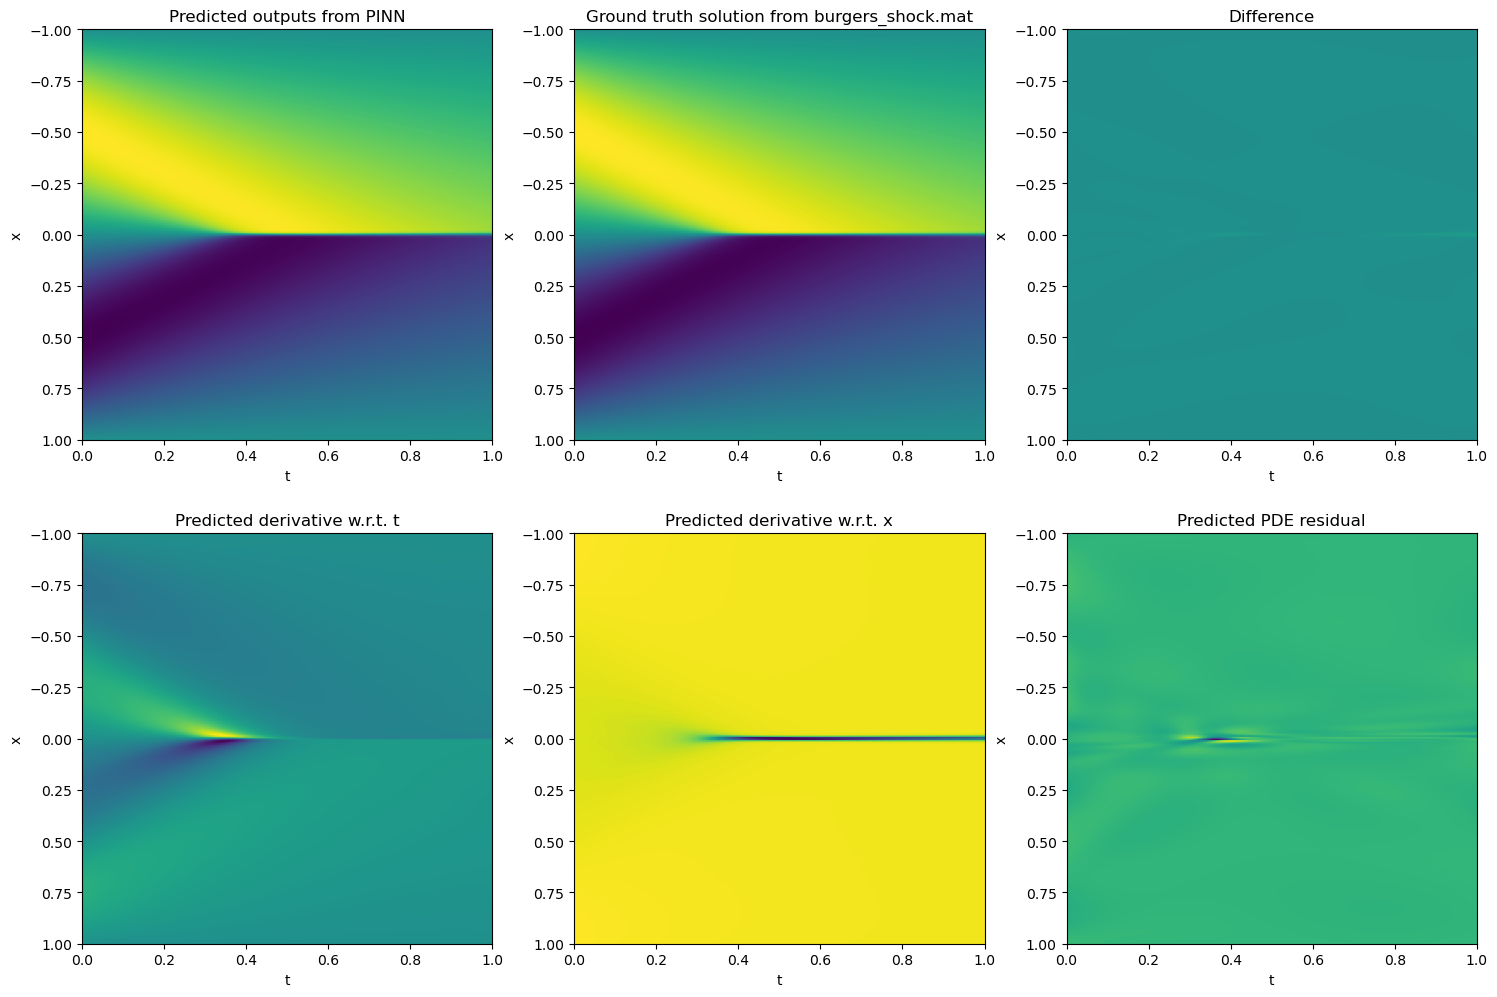

In [14]:
model.eval()

test_output = model(grid_points)
#     test_sample_outputs = model(sample_points)

# Plot predictions, GT, and error over the full range
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(18, 12))
outimg = test_output.cpu().detach().numpy()
outimg = np.reshape(outimg, (xgridsize, tgridsize))

global_min = np.min([np.min(outimg), np.min(usol_full), np.min(np.abs(outimg - usol_full))])
global_max = np.max([np.max(outimg), np.max(usol_full), np.max(np.abs(outimg - usol_full))])
#     global_min = -1
#     global_max = 1

ax1.set_title("Predicted outputs from PINN")
ax1.set_xlabel("t")
ax1.set_ylabel("x")
ax1.set_box_aspect(1)
ax1.imshow(outimg, vmin=global_min, vmax=global_max, extent=[0, 1, 1, -1], aspect='auto')

ax2.set_title("Ground truth solution from burgers_shock.mat")
ax2.set_xlabel("t")
ax2.set_ylabel("x")
ax2.set_box_aspect(1)
ax2.imshow(usol_full, vmin=global_min, vmax=global_max, extent=[0, 1, 1, -1], aspect='auto')

ax3.set_title("Difference")
ax3.set_xlabel("t")
ax3.set_ylabel("x")
ax3.set_box_aspect(1)
ax3.imshow(usol_full - outimg, vmin=global_min, vmax=global_max, extent=[0, 1, 1, -1], aspect='auto')

# Calculate gradients of network
testu_t, testu_x, testu_xx = get_grads(test_output, xv, tv)

testres = testu_t + torch.flatten(test_output) * testu_x - 0.01 / np.pi * testu_xx

test_ut_img = testu_t.cpu().detach().numpy()
test_ut_img = np.reshape(test_ut_img, (xgridsize, tgridsize))
test_ux_img = testu_x.cpu().detach().numpy()
test_ux_img = np.reshape(test_ux_img, (xgridsize, tgridsize))
test_res_img = testres.cpu().detach().numpy()
test_res_img = np.reshape(test_res_img, (xgridsize, tgridsize))

ax4.set_title("Predicted derivative w.r.t. t")
ax4.set_xlabel("t")
ax4.set_ylabel("x")
ax4.set_box_aspect(1)
ax4.imshow(test_ut_img, extent=[0, 1, 1, -1], aspect='auto')

ax5.set_title("Predicted derivative w.r.t. x")
ax5.set_xlabel("t")
ax5.set_ylabel("x")
ax5.set_box_aspect(1)
ax5.imshow(test_ux_img, extent=[0, 1, 1, -1], aspect='auto')

ax6.set_title("Predicted PDE residual")
ax6.set_xlabel("t")
ax6.set_ylabel("x")
ax6.set_box_aspect(1)
ax6.imshow(test_res_img, extent=[0, 1, 1, -1], aspect='auto')
plt.show()

#     # Plot L2 loss over full grid
#     iter_range = np.arange(1, soln.iters+1)
#     error = error.detach().cpu().numpy()
#     plt.plot(iter_range, error[:soln.iters])
#     plt.xlabel("Iteration")
#     plt.ylabel("Relative L2 loss")
#     plt.show()

In [11]:
print(test_output.min(), test_output.max())

tensor(-0.9999, device='cuda:0', dtype=torch.float64, grad_fn=<MinBackward1>) tensor(0.9998, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)


### Train Acc

In [14]:
model.eval()

logits = model(inputs)
_, predicted = torch.max(logits.data, 1)
correct = (predicted == labels).sum().item()
print("Final acc = {:.2f}%".format((100 * correct/len(inputs))))  

Final acc = 54.39%


### Test Acc

In [15]:
val_loop(val_dataloader, model)

Error: 
 Accuracy: 52.6% 



52.63671875

### Feasibility

In [16]:
penalty(model)

tensor(0.0001, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)

In [17]:
l2_penalty(model)

tensor(1.2289e-05, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)

### Graph

In [18]:
import numpy as np
import matplotlib.pyplot as plt

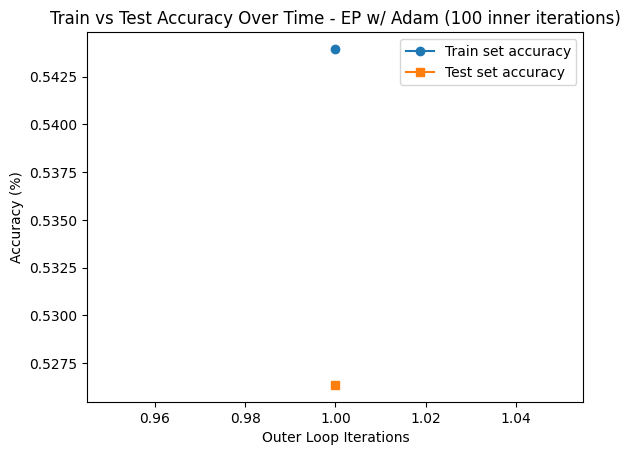

In [19]:
# Plot results
x = np.arange(1, len(train_acc)+1)

plt.plot(x, train_acc, label='Train set accuracy', marker='o')
plt.plot(x, test_acc, label='Test set accuracy', marker='s')

plt.xlabel('Outer Loop Iterations')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Test Accuracy Over Time - EP w/ Adam (100 inner iterations)'.format(batch_size))

plt.legend()

plt.show()

In [20]:
train_acc_1000 = train_acc.copy()
test_acc_1000 = test_acc.copy()

### 3000 inner epochs

In [21]:
train_acc = []
test_acc = []

In [22]:
def exact_penalty_with_pygranso(mu_rho, mu_eps):
    mu = torch.tensor([1.], dtype=double_precision)

    for iteration in range(1000):
        print("Iter", iteration)
        
        # PyGRANSO
        def comb_fn(model):
            # objective function
            phi1_x_mu = phi1(model, mu)
        
            # inequality constraint, matrix form
            ci = None
        
            # equality constraint 
            ce = None
        
            return [phi1_x_mu,ci,ce]
        
        opts = pygransoStruct()
        # option for switching QP solver. We only have osqp as the only qp solver in current version. Default is osqp
        # opts.QPsolver = 'osqp'
        
        # set an intial point
        # All the user-provided data (vector/matrix/tensor) must be in torch tensor format. 
        # As PyTorch tensor is single precision by default, one must explicitly set `dtype=torch.double`.
        # Also, please make sure the device of provided torch tensor is the same as opts.torch_device.
        nvar = getNvarTorch(model.parameters())
        opts.x0 = torch.nn.utils.parameters_to_vector(model.parameters()).detach().reshape(nvar,1)
        opts.torch_device = device
        opts.opt_tol = 1e-5
        opts.viol_eq_tol = 1e-5
        opts.print_level = 1
        opts.print_frequency = 50
        
        # opts.maxit = 1000 yields 80% acc but seems far from reaching stationarity
        #  900 ║  - │   -   ║  0.76603445858 ║   -  │   -  ║ QN │     6 │ 0.031250 ║     1 │ 0.246480   ║ 
        #  950 ║  - │   -   ║  0.70312720877 ║   -  │   -  ║ QN │     6 │ 0.031250 ║     1 │ 0.471985   ║ 
        # ═════╬════════════╬════════════════╬═════════════╬═══════════════════════╬════════════════════╣
        #      ║ Penalty Fn ║                ║  Violation  ║ <--- Line Search ---> ║ <- Stationarity -> ║ 
        # Iter ║ Mu │ Value ║    Objective   ║ Ineq │  Eq  ║ SD │ Evals │     t    ║ Grads │    Value   ║ 
        # ═════╬════════════╬════════════════╬═════════════╬═══════════════════════╬════════════════════╣
        # 1000 ║  - │   -   ║  0.62800096715 ║   -  │   -  ║ QN │     5 │ 0.062500 ║     1 │ 0.430504   ║ 
        opts.maxit = 3000  # Inner epochs
        opts.print_level = iteration <= 2
        
        start = time.time()
        soln = pygranso(var_spec = model,combined_fn = comb_fn, user_opts = opts)
        end = time.time()
        print("Total Wall Time: {}s".format(end - start))
        torch.nn.utils.vector_to_parameters(soln.final.x, model.parameters())
        
        # Exact penalty update
        
        h = penalty(model)
        print("Objective:", f(model, inputs, labels))
        print("Penalty parameter:", mu)
        print("Penalty:", h)
        if h < 1e-3:  # if h(xk ) ≤ τ
            break

        # Choose new penalty parameter µk+1 > µk ;
        if mu * h > mu_eps:
            mu *= mu_rho

        # Choose new starting point (stay as optimal x1, x2)

        print()

### Train Acc

In [24]:
model.eval()

logits = model(inputs)
_, predicted = torch.max(logits.data, 1)
correct = (predicted == labels).sum().item()
print("Final acc = {:.2f}%".format((100 * correct/len(inputs))))  

Final acc = 97.75%


### Test Acc

In [25]:
val_loop(val_dataloader, model)

Error: 
 Accuracy: 67.6% 



67.578125

### Feasibility

In [27]:
penalty(model)

tensor(1.1091e-05, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)

In [29]:
l2_penalty(model)

tensor(9.8434e-07, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)